In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CaseName_Base = 'RTS24_mod1'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'


DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_K: "HI",
                 Folder_L: "CHI",
                }

In [3]:
def LoadingData(dir, folder,result, case, ncluster, cm,folder_out = "4.OutWoInv"):
    #If the folder is A, the name is slightly different (no ByStages in the name and not dependent on nb clust)
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, folder_out, f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), folder_out, f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
    df['Number of clusters'] = ncluster
    df = df.reset_index()

    return df

#Load the weights of the representative periods 
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df

In [ ]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]
nbs_clusters = [(i+1)*10 for i in range(10)]+ [150, 200, 250, 300,350, 400]

folders = [Folder_A]
results = ["NetworkUtilizationPerNode_DC"]

results_dfs = dict()
weights_dfs = dict()
results_w_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    results_w_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        results_w_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
                    results_w_dfs[result][folder][nb_clusters] = results_dfs[result][folder][nb_clusters].merge(weights_dfs[result][folder][nb_clusters][["LoadLevel","Weight"]],on= "LoadLevel")
                                        
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

In [5]:
# Initialize DataFrames to store results
overal_avg_utilization = pd.DataFrame()
all_utils = pd.DataFrame()
i = 0

# Loop through each folder and number of clusters
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters:
        # Concatenate the individual results to the all_utils DataFrame
        #all_utils = pd.concat([all_utils, results_dfs[result][folder][nb_clusters]])
        all_utils = pd.concat([all_utils, results_w_dfs[result][folder][nb_clusters]])


A.The_full_year_MILP


## 2D kernel density plots

In [6]:
def extract_FYMILP_one_line(all_utils_FYMILP,node_pair): 
    filter_this_line = (all_utils_FYMILP["InitialNode"] == node_pair[0]) & (all_utils_FYMILP["FinalNode"] == node_pair[1])
    utils_this_line_FYMILP = all_utils_FYMILP[filter_this_line]

    ts_this_line_FYMILP = utils_this_line_FYMILP.GWh.to_numpy()
    return ts_this_line_FYMILP

def extract_CM_one_line(cm,nbc): 
    ts_CM_All_lines = pd.read_csv(f"Y.FYTS_from_ByStages/RTS24_mod1/{cm}/NetworkUtilization_nc{nbc}.csv",header = [0,1],index_col=0)
    ts_this_line_CM = ts_CM_All_lines.loc[:,node_pair].to_numpy()
    return ts_this_line_CM


In [7]:
## Extract fyts for single line 

## FYMILP
filter_FYMILP = (all_utils["Clustering method"] == "FYMILP") & (all_utils["Number of clusters"] == 10) & (all_utils["Circuit"] == "eac1") 

all_utils_FYMILP = all_utils[filter_FYMILP]
unique_node_pairs = [tuple(x) for x in all_utils_FYMILP[['InitialNode', 'FinalNode']].drop_duplicates().values.tolist()]

node_pair = unique_node_pairs[0]

ts_this_line_FYMILP = extract_FYMILP_one_line(all_utils_FYMILP,node_pair)
##CM 
cm = "CHI"
nbc = 200

ts_CM_All_lines = pd.read_csv(f"Y.FYTS_from_ByStages/RTS24_mod1/{cm}/NetworkUtilization_nc{nbc}.csv",header = [0,1],index_col=0)
ts_this_line_CM = ts_CM_All_lines.loc[:,node_pair].to_numpy()
ts_this_line_CM = extract_CM_one_line(cm,nbc)

np.corrcoef(ts_this_line_FYMILP,ts_this_line_CM)


array([[1.        , 0.90631982],
       [0.90631982, 1.        ]])

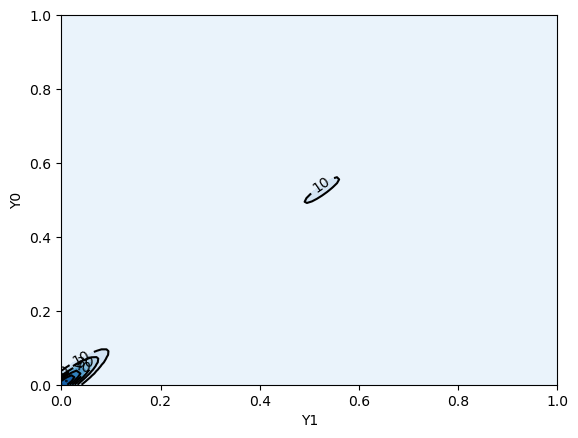

In [8]:
import scipy.stats as st

x = ts_this_line_FYMILP
y = ts_this_line_CM


xmin, xmax = 0, 1
ymin, ymax = 0, 1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

plt.show()

In [7]:
## Extract fyts for multiple lines 


## FYMILP
filter_FYMILP = (all_utils["Clustering method"] == "FYMILP") & (all_utils["Number of clusters"] == 10) & (all_utils["Circuit"] == "eac1") 

all_utils_FYMILP = all_utils[filter_FYMILP]
unique_node_pairs = [tuple(x) for x in all_utils_FYMILP[['InitialNode', 'FinalNode']].drop_duplicates().values.tolist()]


##CM 
cm = "CHI"
nbc = 20

nb_lines = len(unique_node_pairs)
ts_all_lines_CM=np.zeros(8736*nb_lines)
ts_all_lines_FYMILP=np.zeros(8736*nb_lines)

for i,node_pair in enumerate(unique_node_pairs[:nb_lines]): 
    ts_this_line_FYMILP = extract_FYMILP_one_line(all_utils_FYMILP,node_pair)
    ts_this_line_CM = extract_CM_one_line(cm,nbc)
    i_start = i*8736
    i_end = (i+1)*8736
    ts_all_lines_FYMILP[i_start:i_end]=ts_this_line_FYMILP
    ts_all_lines_CM[i_start:i_end] = ts_this_line_CM
    
np.corrcoef(ts_all_lines_FYMILP,ts_all_lines_CM)

array([[1.        , 0.69251766],
       [0.69251766, 1.        ]])

In [ ]:
import scipy.stats as st
min_value = 0.9
max_value = 1
x = ts_all_lines_CM
y = ts_all_lines_FYMILP
xmin, xmax = min_value, max_value
ymin, ymax = min_value, max_value

#Filter values
filter_greater_than = max_value>(ts_all_lines_FYMILP>min_value)

x = x[filter_greater_than]
y = y[filter_greater_than]


# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(f'{cm}')
ax.set_ylabel('FYMILP')
plt.savefig(f"Z.Figures/KDE2D/LinUtil_{cm}_nc{nbc}_th{min_value}_{max_value}.png")
plt.show()

In [11]:
filter_FYMILP = (all_utils["Clustering method"] == "FYMILP") & (all_utils["Number of clusters"] == 10) & (all_utils["Circuit"] == "eac1") 

bm_utils = all_utils[filter_FYMILP].GWh.to_numpy()

cm = "R&D"
nbc = 50
filter_case = (all_utils["Clustering method"] == cm) & (all_utils["Number of clusters"] == nbc) & (all_utils["Circuit"] == "eac1") 
case_utils = all_utils[filter_case].GWh.to_numpy()


cm = "CHI"
nbc = 50
filter_case = (all_utils["Clustering method"] == cm) & (all_utils["Number of clusters"] == nbc) & (all_utils["Circuit"] == "eac1") 
case_utils_2 = all_utils[filter_case].GWh.to_numpy()


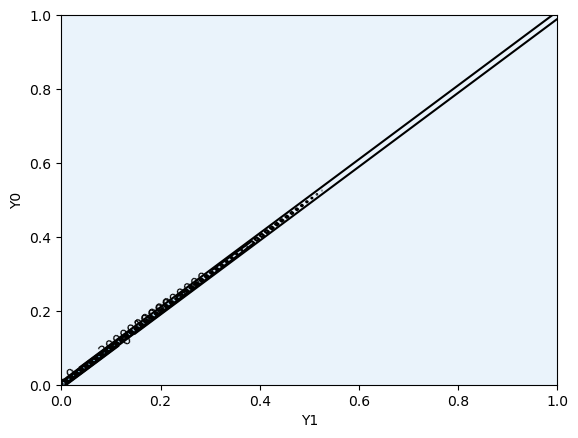

In [16]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = bm_utils
y = bm_utils
xmin, xmax = 0, 1
ymin, ymax = 0, 1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()

<Axes: >

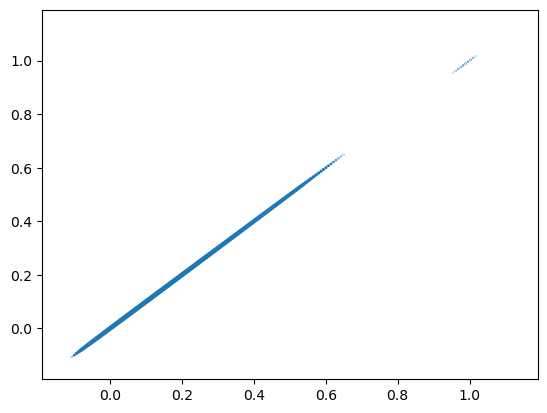

In [15]:
sns.kdeplot(x = case_utils, y = case_utils)

In [ ]:
sns.kdeplot(x = bm_utils, y = case_utils)